In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import BorderlineSMOTE
import joblib
from collections import Counter

In [2]:
data = pd.read_csv("C:\\Users\\LENOVO\\Downloads\\Online_Payments_Fraud_Detection.csv")
print(data.head())
print(data.info())
print(data['isFraud'].value_counts())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 co

In [3]:
fraudulent_transactions = data[data['isFraud'] == 1].head(3)
print(fraudulent_transactions)

     step      type  amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
2       1  TRANSFER   181.0  C1305486145          181.0             0.0   
3       1  CASH_OUT   181.0   C840083671          181.0             0.0   
251     1  TRANSFER  2806.0  C1420196421         2806.0             0.0   

       nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
2    C553264065             0.0             0.0        1               0  
3     C38997010         21182.0             0.0        1               0  
251  C972765878             0.0             0.0        1               0  


In [4]:
duplicate_rows = data[data.duplicated()]

if not duplicate_rows.empty:
    print("Duplicate rows found:")
    print(duplicate_rows)
else:
    print("No duplicate rows found.")

No duplicate rows found.


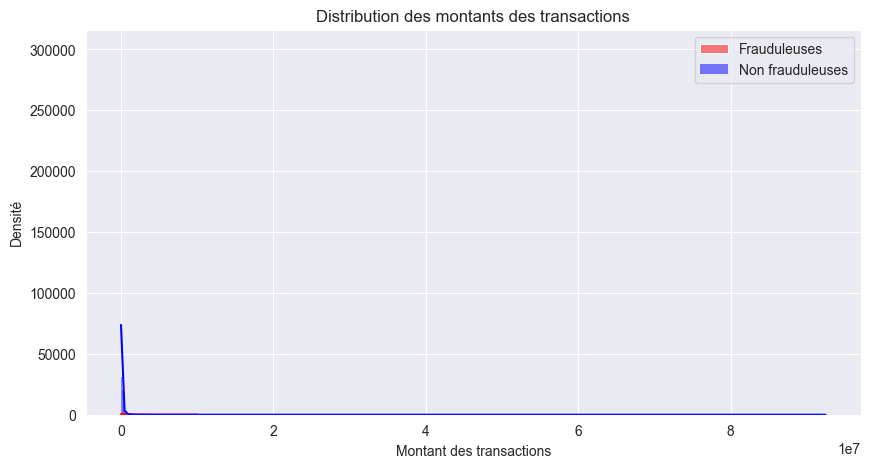

In [5]:
# Visualize transaction amounts
plt.figure(figsize=(10, 5))
sns.histplot(data[data['isFraud'] == 1]['amount'], color='red', label='Frauduleuses', kde=True)
sns.histplot(data[data['isFraud'] == 0]['amount'], color='blue', label='Non frauduleuses', kde=True)
plt.title('Distribution des montants des transactions')
plt.xlabel('Montant des transactions')
plt.ylabel('Densité')
plt.legend()
plt.savefig('distribution_transactions.png')
plt.show()
plt.close()

In [6]:
# Split Train/Test
X = data.drop(['isFraud', 'type', 'nameOrig', 'nameDest', 'step'], axis=1)
y = data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [7]:
# Define the Borderline-SMOTE sampler
borderline_smote = BorderlineSMOTE(sampling_strategy=0.1, random_state=42)
X_train_resampled, y_train_resampled = borderline_smote.fit_resample(X_train, y_train)
print("Resampled dataset shape:", Counter(y_train_resampled))

Resampled dataset shape: Counter({0: 4765805, 1: 476580})


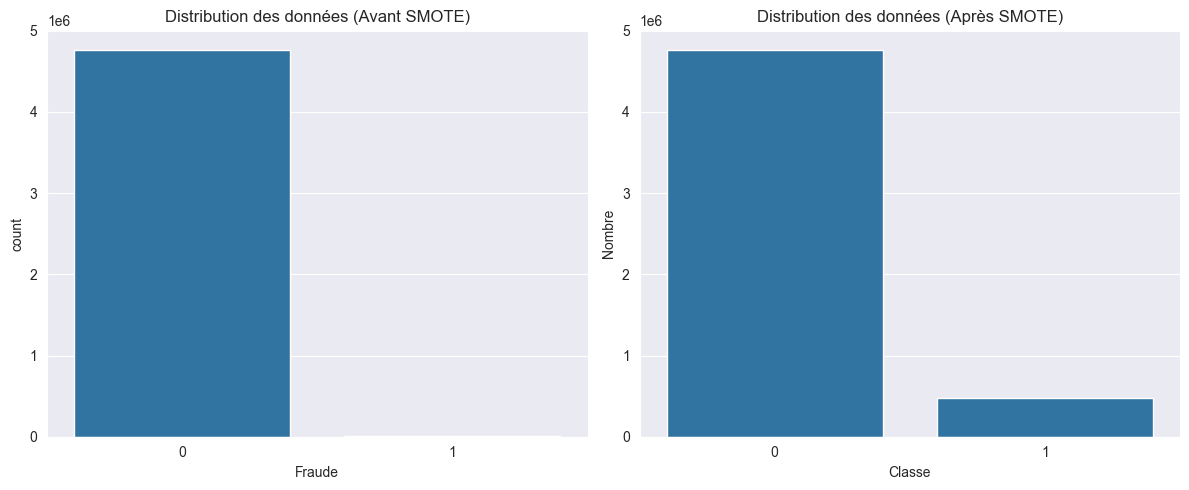

In [8]:
# Distribution des données avant et après SMOTE
plt.figure(figsize=(12, 5))

# Distribution avant SMOTE
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Distribution des données (Avant SMOTE)')
plt.xlabel('Fraude')

# Distribution après SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('Distribution des données (Après SMOTE)')
plt.xlabel('Classe')
plt.ylabel('Nombre')
plt.tight_layout()
plt.savefig('distribution_avant_apres_smote.png')
plt.show()


In [9]:
# Vérification des valeurs manquantes
print(X_train_resampled.isnull().sum())

amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFlaggedFraud    0
dtype: int64


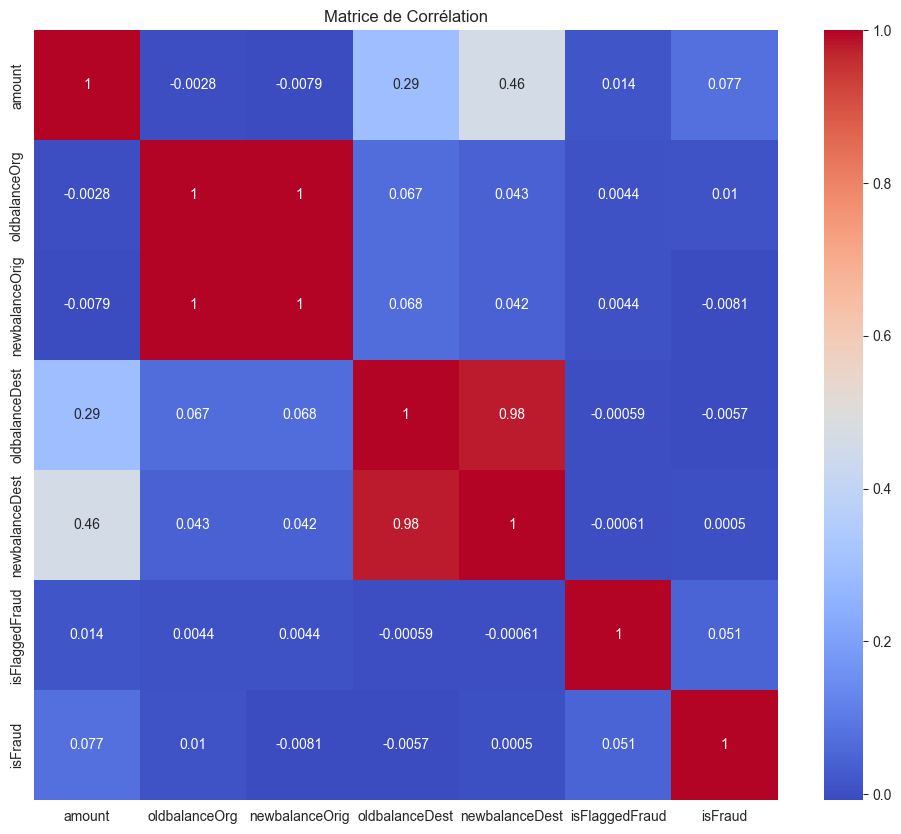

In [10]:
# Correlation matrix
train_data = pd.concat([X_train, y_train], axis=1)
correlation_matrix = train_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de Corrélation')
plt.savefig('matrice_correlation.png')
plt.show()

In [11]:
# Feature selection
selected_features = ['oldbalanceOrg' ,'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [12]:
# Function to display metrics
def display_metrics(y_true, y_pred, y_pred_proba=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba) if y_pred_proba is not None else None
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")
    print("\n")

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }

    return metrics


In [13]:
# Function to train and evaluate a model
def train_and_evaluate(model, X_train, y_train, X_test, y_test, selected_features=None):
    if selected_features is not None:
        X_train = X_train[selected_features]
        X_test = X_test[selected_features]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    return display_metrics(y_test, y_pred, y_pred_proba)


In [14]:
# Logistic Regression Models
models = {
    "Logistic Regression Unbalanced No FS": LogisticRegression(solver='liblinear', max_iter=1000),
    "Logistic Regression Balanced No FS": LogisticRegression(solver='liblinear', max_iter=1000),
    "Logistic Regression Unbalanced FS": LogisticRegression(solver='liblinear', max_iter=1000),
    "Logistic Regression Balanced FS": LogisticRegression(solver='liblinear', max_iter=1000)
}

In [15]:
# Train and evaluate Logistic Regression models
logistic_metrics = {}
random_forest_metrics = {}
print("Training and evaluating Logistic Regression models...")
for name, model in models.items():
    print(f"Training and evaluating {name}...")
    if "Balanced" in name:
        metrics = train_and_evaluate(model, X_train_resampled, y_train_resampled, X_test, y_test, selected_features if "FS" in name else None)
    else:
        metrics = train_and_evaluate(model, X_train, y_train, X_test, y_test, selected_features if "FS" in name else None)
    logistic_metrics[name] = metrics


Training and evaluating Logistic Regression models...
Training and evaluating Logistic Regression Unbalanced No FS...
Accuracy: 0.9398
Precision: 0.0105
Recall: 0.4900
F1 Score: 0.0206
ROC AUC: 0.8014


Training and evaluating Logistic Regression Balanced No FS...
Accuracy: 0.8943
Precision: 0.0113
Recall: 0.9318
F1 Score: 0.0223
ROC AUC: 0.9642


Training and evaluating Logistic Regression Unbalanced FS...
Accuracy: 0.9398
Precision: 0.0105
Recall: 0.4900
F1 Score: 0.0206
ROC AUC: 0.8014


Training and evaluating Logistic Regression Balanced FS...
Accuracy: 0.8943
Precision: 0.0113
Recall: 0.9318
F1 Score: 0.0223
ROC AUC: 0.9642



In [16]:
# Random Forest Models
models_rf = {
    "Random Forest Unbalanced No FS": RandomForestClassifier(random_state=42),
    "Random Forest Balanced No FS": RandomForestClassifier(random_state=42),
    "Random Forest Unbalanced FS": RandomForestClassifier(random_state=42),
    "Random Forest Balanced FS": RandomForestClassifier(random_state=42)
}

In [17]:
# Train and evaluate Random Forest models
print("Training and evaluating Random Forest models...")
for name, model in models_rf.items():
    print(f"Training and evaluating {name}...")
    if "Balanced" in name:
        metrics = train_and_evaluate(model, X_train_resampled, y_train_resampled, X_test, y_test,
                                     selected_features if "FS" in name else None)
    else:
        metrics = train_and_evaluate(model, X_train, y_train, X_test, y_test,
                                     selected_features if "FS" in name else None)
    random_forest_metrics[name] = metrics

Training and evaluating Random Forest models...
Training and evaluating Random Forest Unbalanced No FS...
Accuracy: 0.9994
Precision: 0.8392
Recall: 0.6357
F1 Score: 0.7234
ROC AUC: 0.9123


Training and evaluating Random Forest Balanced No FS...
Accuracy: 0.9956
Precision: 0.1940
Recall: 0.7720
F1 Score: 0.3101
ROC AUC: 0.9426


Training and evaluating Random Forest Unbalanced FS...
Accuracy: 0.9994
Precision: 0.8392
Recall: 0.6357
F1 Score: 0.7234
ROC AUC: 0.9123


Training and evaluating Random Forest Balanced FS...
Accuracy: 0.9956
Precision: 0.1940
Recall: 0.7720
F1 Score: 0.3101
ROC AUC: 0.9426


In [18]:
# Print the collected metrics
print("Logistic Regression Metrics:")
print(logistic_metrics)
print("\nRandom Forest Metrics:")
print(random_forest_metrics)

# Convert metrics to DataFrames
logistic_df = pd.DataFrame.from_dict(logistic_metrics, orient='index')
random_forest_df = pd.DataFrame.from_dict(random_forest_metrics, orient='index')

# Concatenate DataFrames
metrics_df = pd.concat([logistic_df, random_forest_df], axis=0)

# Save to CSV
metrics_df.to_csv('model_metrics.csv')


Logistic Regression Metrics:
{'Logistic Regression Unbalanced No FS': {'Accuracy': 0.9397656940065571, 'Precision': 0.010504223616752462, 'Recall': 0.49001461276181196, 'F1 Score': 0.020567549885508667, 'ROC AUC': 0.8014218112876833}, 'Logistic Regression Balanced No FS': {'Accuracy': 0.8943309517148597, 'Precision': 0.011262481160512434, 'Recall': 0.9318071115440818, 'F1 Score': 0.022255961002623482, 'ROC AUC': 0.9642218317706666}, 'Logistic Regression Unbalanced FS': {'Accuracy': 0.9397656940065571, 'Precision': 0.010504223616752462, 'Recall': 0.49001461276181196, 'F1 Score': 0.020567549885508667, 'ROC AUC': 0.8014218112876833}, 'Logistic Regression Balanced FS': {'Accuracy': 0.8943309517148597, 'Precision': 0.011262481160512434, 'Recall': 0.9318071115440818, 'F1 Score': 0.022255961002623482, 'ROC AUC': 0.9642218317706666}}

Random Forest Metrics:
{'Random Forest Unbalanced No FS': {'Accuracy': 0.9993725855072282, 'Precision': 0.8392282958199357, 'Recall': 0.6356551388212373, 'F1 Sco

In [21]:
# Save models
joblib.dump(models["Logistic Regression Balanced No FS"], 'logistic_regression_balanced_no_fs_model.pkl')
joblib.dump(models["Logistic Regression Balanced FS"], 'logistic_regression_balanced_fs_model.pkl')
joblib.dump(models_rf["Random Forest Balanced No FS"], 'random_forest_balanced_no_fs_model.pkl')
joblib.dump(models_rf["Random Forest Balanced FS"], 'random_forest_balanced_fs_model.pkl')

['random_forest_balanced_fs_model.pkl']

In [19]:
random_search_fs_balanced = RandomForestClassifier(n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_depth=10, criterion='gini')
random_search_fs_balanced.fit(X_train_resampled[selected_features], y_train_resampled)
predictions_balanced_fs = random_search_fs_balanced.predict(X_test[selected_features])

In [22]:
accuracy = accuracy_score(y_test, predictions_balanced_fs)
precision = precision_score(y_test, predictions_balanced_fs)
recall = recall_score(y_test, predictions_balanced_fs)
f1 = f1_score(y_test, predictions_balanced_fs)

print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Accuracy: 0.9915
Precision: 0.1169
Recall: 0.8553
F1 Score: 0.2056


In [24]:
fraudulent_transactions = train_data[train_data['isFraud'] == 1].head(5)
print(fraudulent_transactions)

             amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
6273165  4128853.75     4128853.75             0.0     13982778.91   
1030477    79441.66       79441.66             0.0            0.00   
6308242    47061.52       47061.52             0.0       372871.76   
728195    128133.00      128133.00             0.0       160395.62   
4388770  1033878.67     1033878.67             0.0            0.00   

         newbalanceDest  isFlaggedFraud  isFraud  
6273165     18111632.66               0        1  
1030477            0.00               0        1  
6308242       419933.28               0        1  
728195        288528.62               0        1  
4388770            0.00               0        1  


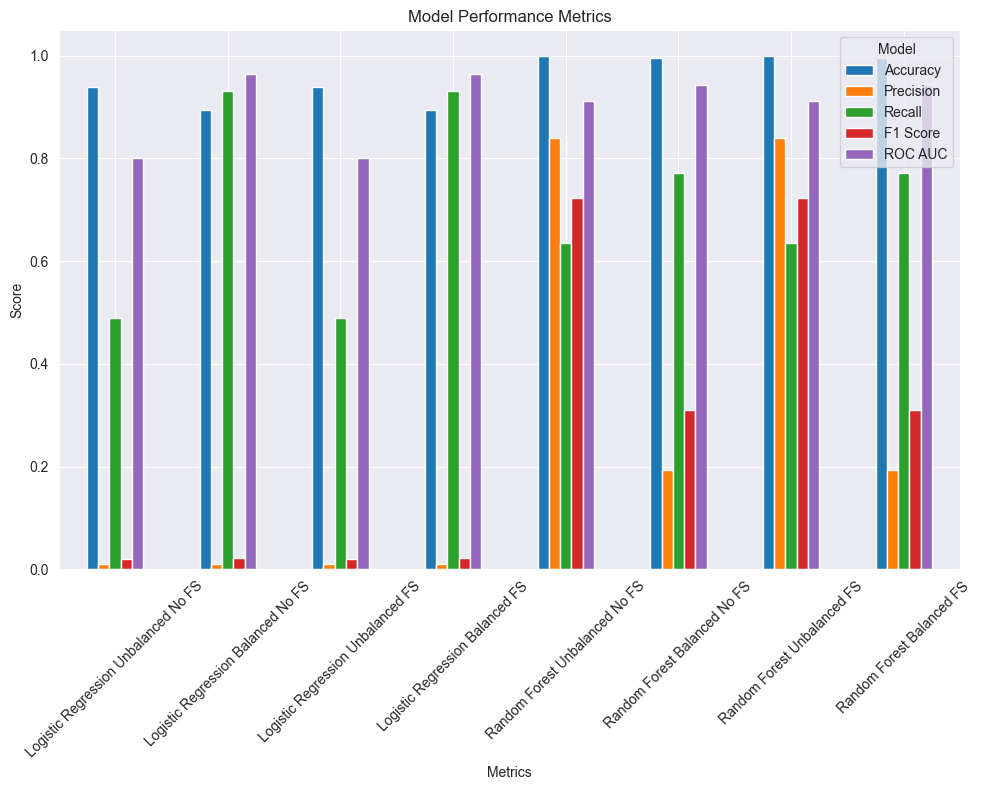

In [28]:
metrics_df.plot(kind='bar', figsize=(10, 8))
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()

plt.savefig('Performance_Metrics_graph.png')

plt.show()